# *SARIMA Model*

In [2]:
import pandas as pd
from statsmodels.api import tsa
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error 
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import ds_tools as dst
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

In [3]:
import warnings
warnings.filterwarnings("ignore")

A **S**easonal **A**uto-**R**egressive **I**ntegrated **M**oving **A**verage (SARIMA) model considers autoregressive (lagged), integrated (differenced), and moving average values of a dataset when making predictions. The model also takes into consideration the same values for the seasonal component of the data, as well as the seasonal period. 


In [4]:
# recall DF_dict
DF_dict = pd.read_pickle('data/DF_dict.pkl')

In [5]:
day_df = pd.read_pickle('data/LCL_unstack_wks.pkl')
day_df.head()

tariff,Std,ToU
DateTime,,
2012-01-01,0.523669,0.528838
2012-01-08,0.540989,0.541720
2012-01-15,0.532780,0.526268
2012-01-22,0.550542,0.533956
2012-01-29,0.553962,0.503050


---
## *Seasonal Decomposition*

For the SARIMA model, we will consider the weekly values as this has only one degree of seasonality. The SARIMA model may struggle to pick up the multiple seasonalities present in the daily and hourly data. The hourly and daily granularities will also likely exceed the computing resources available.

We can examine the characteristics of the data by carrying out a seasonal decomposition to see the trend, seasonal, and residual components of the dataset. 

In [6]:
decomps_wks = dst.decompose_DFs(day_df, 'multiplicative', 52) 
decomps_wks.head()

,Std_Trend,Std_Seasonal,Std_Residual,ToU_Trend,ToU_Seasonal,ToU_Residual
DateTime,,,,,,
2012-01-01,0.455102,1.187475,0.968999,0.449224,1.200659,0.980482
2012-01-08,0.454635,1.198119,0.993175,0.447950,1.208685,1.000535
2012-01-15,0.454167,1.191258,0.984750,0.446676,1.183587,0.995437
2012-01-22,0.453700,1.251485,0.969607,0.445403,1.243797,0.963836
2012-01-29,0.453233,1.246853,0.980266,0.444129,1.219819,0.928552


In [7]:
prds = ['Trend', 'Seasonal', 'Residual']

fig = make_subplots(rows=3, cols=1, subplot_titles=prds, shared_xaxes=False)

for i in range(len(prds)):
    prd = prds[i]
    df = decomps_wks     

    fig.add_trace(                          # Plot standard tariff
        go.Line(
            x=df.index, y=df.iloc[:,i], 
            name = 'Standard', 
            line_color = '#F2A74B',
            legendgroup = prd
            ),
        row = i+1,
        col = 1,
    )

    fig.add_trace(                          # Plot variable tariff
        go.Line(
            x=df.index, y=df.iloc[:,i+3], 
            name = 'Variable',
            line_color = '#415885',
            legendgroup = prd
            ),
        row = i+1,
        col = 1
    )

    fig.update_xaxes(title_text='Date-Time', row=i+1, col=1)
    fig.update_yaxes(title_text='Multiplier', row=i+1, col=1)

    fig.update_layout(
        legend_title = "Tariff", 
        title = "Seasonal Decomposition of Weekly Average Power Consumption",
        legend_tracegroupgap=350,
        height= 1200
    )

fig.show()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




From the seasonal decomposition, we can see some clear patterns. Interestingly, the trend appears to be negative, indicating a general reduction in household power consumption over time. This could be due to the effects of climate change resulting in warmer winters, meaning that less energy is spent on heating homes during the winter. Alternatively, this could show that appliances are simply becoming more efficient and so demand less power.

We can also see from the trend that the power consumption of both tariffs is more similar at the start of the series, the variable power consumption then drops before maintaining a roughly constant offset from the standard tariff. This shows the period where power consumption behaviour changes due to the variable tariff notifications.

As we would expect, can also see a clear seasonality in the seasonal component plot. There are peaks in January, when the weather would be coldest, and troughs in August, the middle of summer. This pattern is due to both more power being required for heating, and people simply spending more time indoors during winter and thus a higher power draw in general for everyday appliances such as kettles and televisions, for example.

---
## *Standard Tariff*

To construct our SARIMA model, we need to determine how many lagged and moving average components should be considered. We can do this by examining the ACF and PACF plots. We will also apply a differencing of 1, this enforces stationarity in the dataset by considering only the point to point changes. 

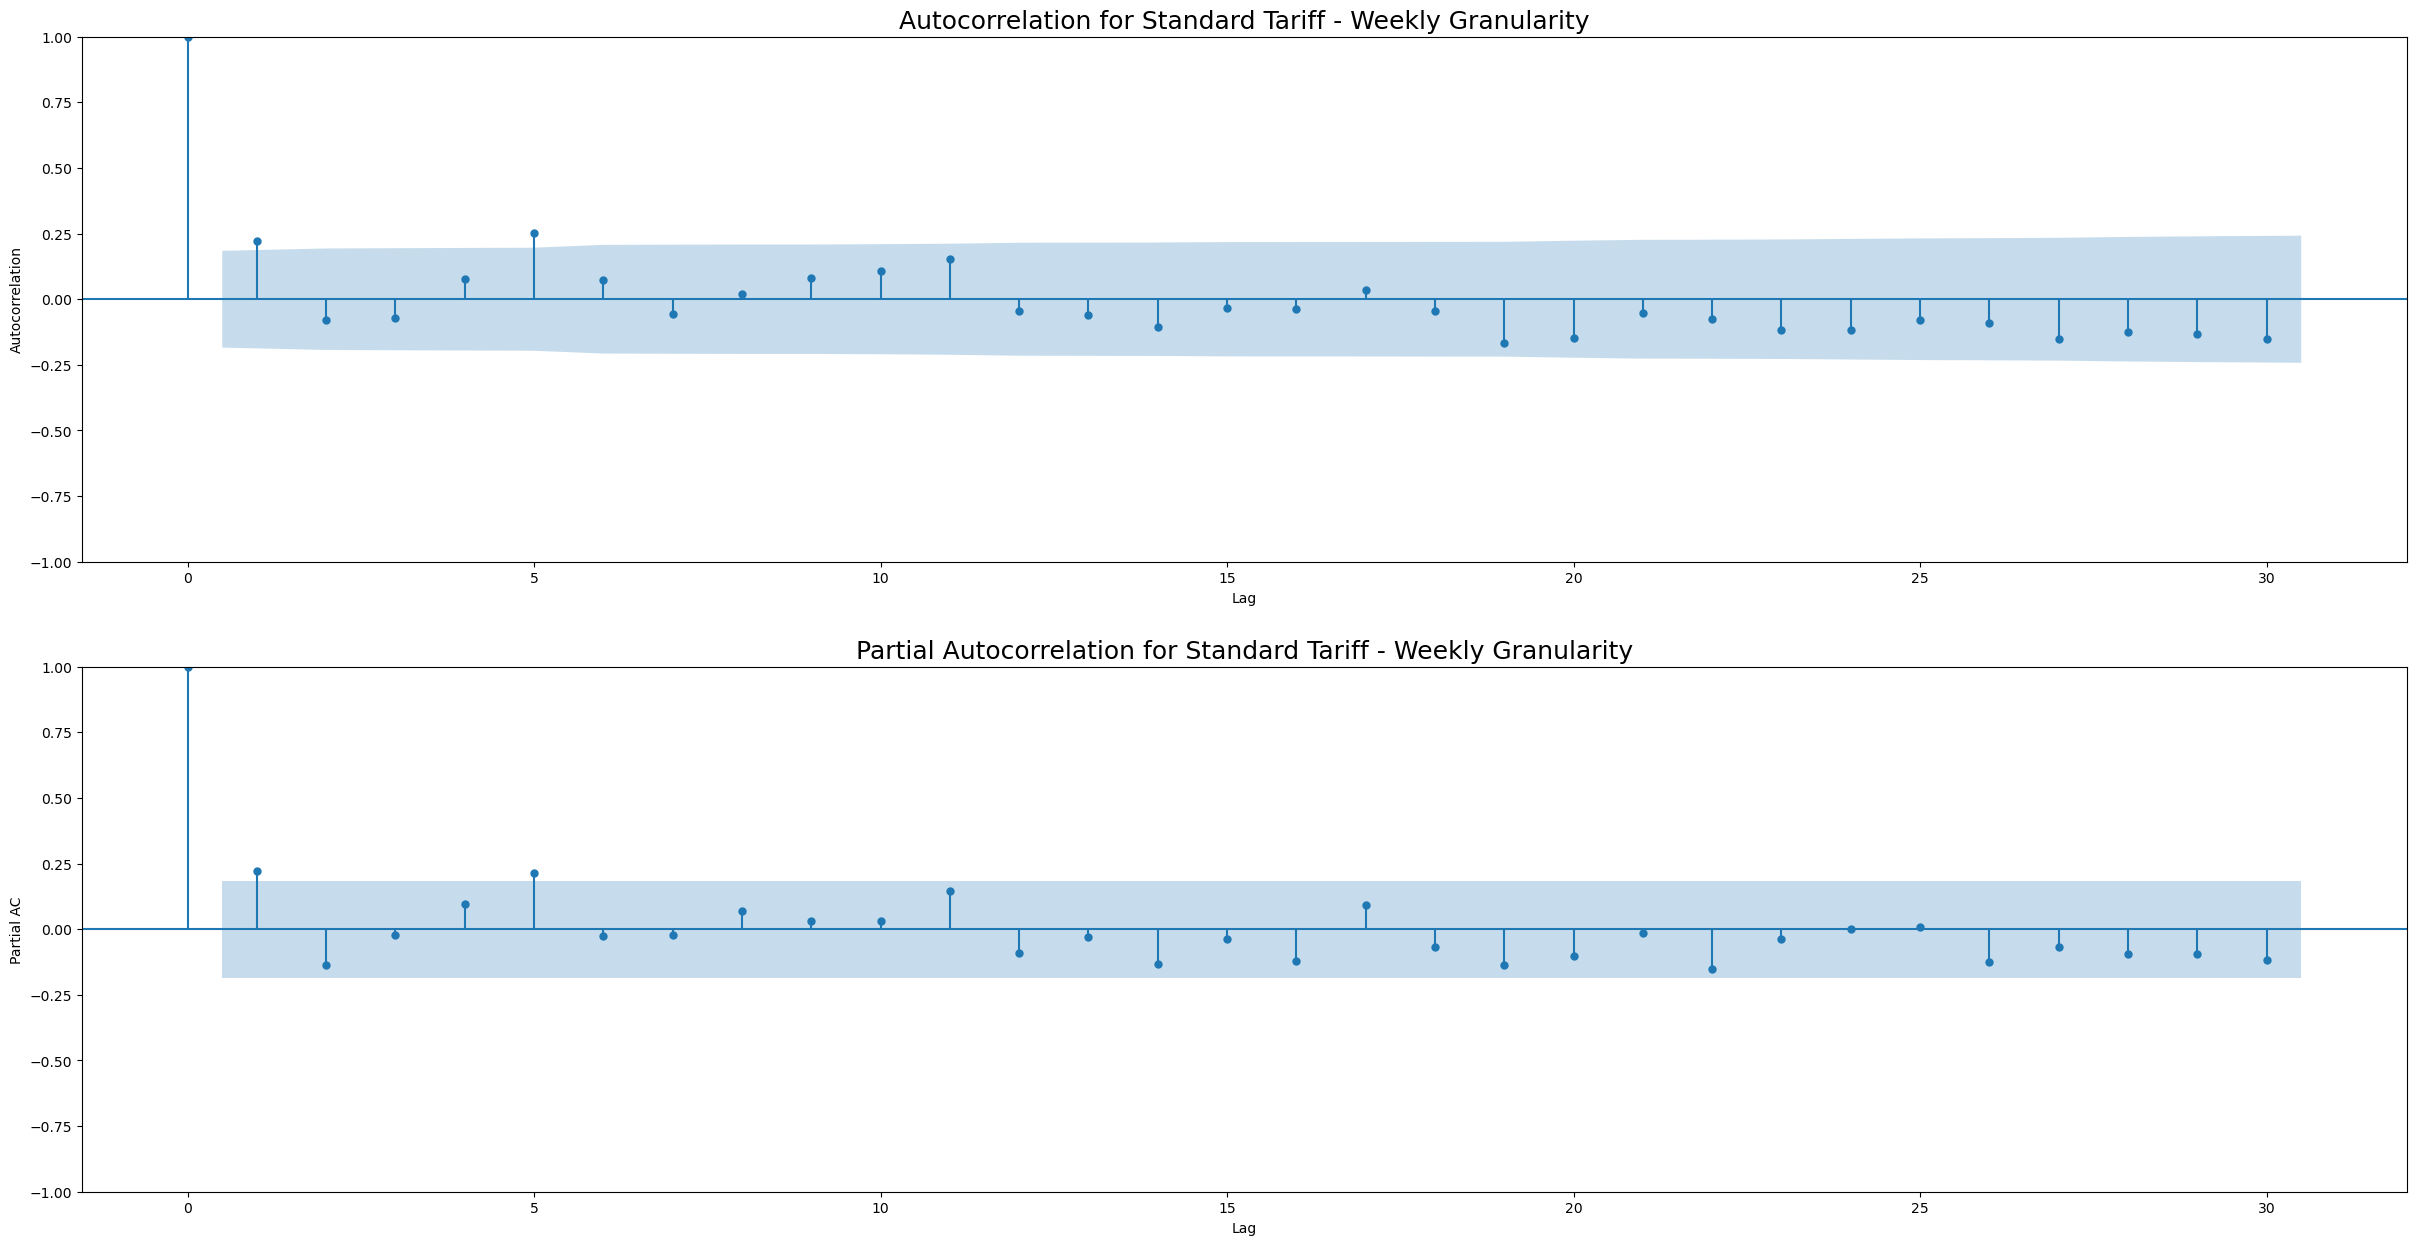

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(day_df["Std"].diff(1).dropna(), lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Standard Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(day_df["Std"].diff(1).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Standard Tariff - Weekly Granularity', fontsize = 18)
plt.show()

The points inside the blue area are considered insignificant. Points up to and including the last point outside the blue area should be considered in the model. In this case. 

The auto-regressive term, $p$, will be informed by the PACF plot. In this case, the $p$ value should be 1, since the point beyond this is below the significance required to be considered in the model.

The moving average term, $q$, is informed by the ACF plot. For the same reason as the $p$ value, only the first point will be considered in the model.

The series has also been differenced once, so the difference term, $d$, will be 1.

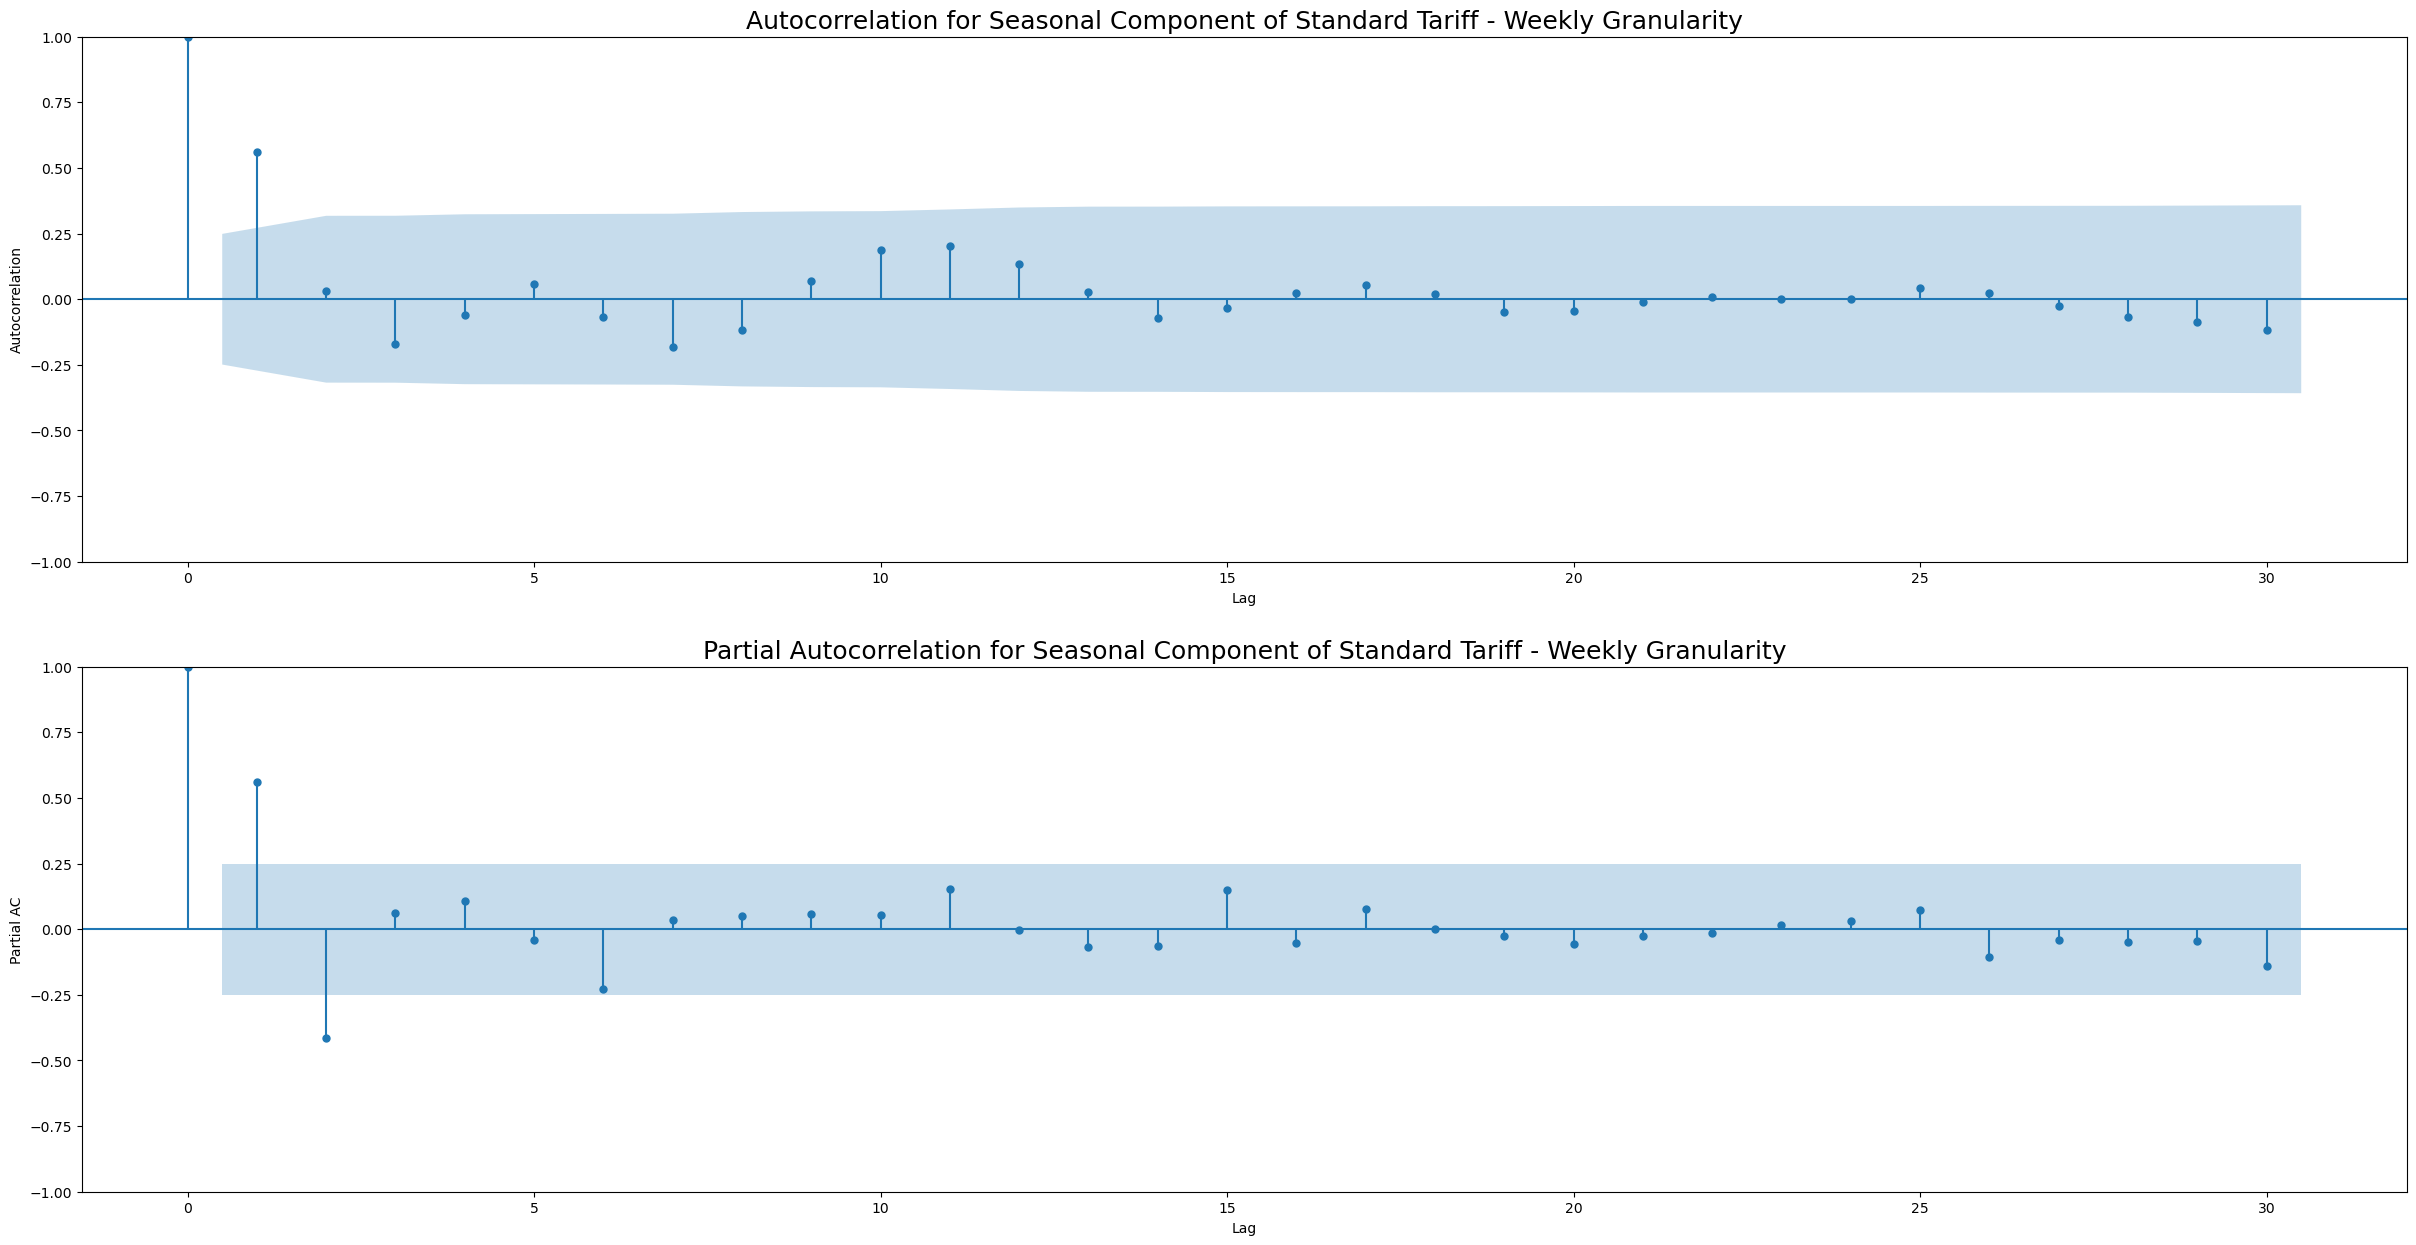

In [9]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(day_df["Std"].diff(52).dropna(), lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Seasonal Component of Standard Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(day_df["Std"].diff(52).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Seasonal Component of Standard Tariff - Weekly Granularity', fontsize = 18)
plt.show()

The seasonal components of the SARIMA model will be informed by ACF and PACF plots of the series lagged by the number of points in a seasonal period, in this case 52 as we are considering a weekly granularity over yearly periods.

From these plots, we can see that the seasonal $P$ value will be 2, and the seasonal $Q$ value will be 1. The series again has only been differenced once, so the seasonal $D$ value will be 1.

The SARIMA models will be tested using a 5-fold cross validation. This will train and test the model on 5 sequential portions of the dataset. The errors will then be averaged to give a cross validated mean absolute percentage error. Training and testing on different parts of the dataset will reduce the possibility that the model is overfitted on any particular part of the data, or that the test predictions are accurate by chance.

In [32]:
tscv = TimeSeriesSplit(n_splits=5)
tscv.split(day_df['Std'])
Std_mapes = []

for train, test in tscv.split(day_df['Std']):

    Std_train = day_df['Std'][train]
    Std_test = day_df['Std'][test]

    SARIMA_Std = SARIMAX(Std_train, order=(1, 1, 1), seasonal_order = (2,1,1,52)) 
    SARIMA_Std = SARIMA_Std.fit()

    test_pred = SARIMA_Std.predict(start = Std_test.index[0], end = Std_test.index[-1]).shift(-1).dropna()
    Std_mapes.append(mean_absolute_percentage_error(Std_test.head(-1), test_pred))

train_pred = SARIMA_Std.predict(start = Std_train.index[0], end = Std_train.index[-1]).shift(-1).dropna()

print(f'\n\n===========================================\
    \nCross-validated MAPE: {round(np.mean(Std_mapes)*100, 2)}%\
    \nFinal fold train MAPE: {round(mean_absolute_percentage_error(Std_train.head(-1), train_pred)*100, 2)}%\
    \nFinal fold test MAPE: {round(mean_absolute_percentage_error(Std_test.head(-1), test_pred)*100, 2)}%\
    \n===========================================\
    \n\n{SARIMA_Std.summary()}')



Cross-validated MAPE: 11.48%    
Final fold train MAPE: 2.13%    
Final fold test MAPE: 6.53%    

                                     SARIMAX Results                                      
Dep. Variable:                                Std   No. Observations:                   95
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 52)   Log Likelihood                  82.706
Date:                            Sat, 05 Nov 2022   AIC                           -153.411
Time:                                    15:16:00   BIC                           -142.985
Sample:                                01-01-2012   HQIC                          -149.590
                                     - 10-20-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        

We can see that many of the $P$ values for this model are above 0.05. This implies that the points being considered are irrelevant to the model. We will begin by reducing the auto-regressive seasonal component to 1, as this has one of the highest $P$ values

In [49]:
tscv = TimeSeriesSplit(n_splits=5)
tscv.split(day_df['Std'])
Std_mapes = []

for train, test in tscv.split(day_df['Std']):

    Std_train = day_df['Std'][train]
    Std_test = day_df['Std'][test]

    SARIMA_Std = SARIMAX(Std_train, order=(1, 1, 1), seasonal_order = (1,1,1,52)) # Set P to 1
    SARIMA_Std = SARIMA_Std.fit()

    test_pred = SARIMA_Std.predict(start = Std_test.index[0], end = Std_test.index[-1]).shift(-1).dropna()
    Std_mapes.append(mean_absolute_percentage_error(Std_test.head(-1), test_pred))

train_pred = SARIMA_Std.predict(start = Std_train.index[0], end = Std_train.index[-1]).shift(-1).dropna()

print(f'\n\n===========================================\
    \nCross-validated MAPE: {round(np.mean(Std_mapes)*100, 2)}%\
    \nFinal fold train MAPE: {round(mean_absolute_percentage_error(Std_train.head(-1), train_pred)*100, 2)}%\
    \nFinal fold test MAPE: {round(mean_absolute_percentage_error(Std_test.head(-1), test_pred)*100, 2)}%\
    \n===========================================\
    \n\n{SARIMA_Std.summary()}')



Cross-validated MAPE: 11.33%    
Final fold train MAPE: 2.13%    
Final fold test MAPE: 6.48%    

                                     SARIMAX Results                                      
Dep. Variable:                                Std   No. Observations:                   95
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                  82.637
Date:                            Sat, 05 Nov 2022   AIC                           -155.275
Time:                                    15:48:54   BIC                           -146.586
Sample:                                01-01-2012   HQIC                          -152.090
                                     - 10-20-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        

There is a small reduction in MAPE, next we will eliminate the auto-regressive term completely as this still has a $P$ value of 1.0.

In [34]:
tscv = TimeSeriesSplit(n_splits=5)
tscv.split(day_df['Std'])
Std_mapes = []

for train, test in tscv.split(day_df['Std']):

    Std_train = day_df['Std'][train]
    Std_test = day_df['Std'][test]

    SARIMA_Std = SARIMAX(Std_train, order=(1, 1, 1), seasonal_order = (0,1,1,52)) # Set P to 0
    SARIMA_Std = SARIMA_Std.fit()

    test_pred = SARIMA_Std.predict(start = Std_test.index[0], end = Std_test.index[-1]).shift(-1).dropna()
    Std_mapes.append(mean_absolute_percentage_error(Std_test.head(-1), test_pred))

train_pred = SARIMA_Std.predict(start = Std_train.index[0], end = Std_train.index[-1]).shift(-1).dropna()

print(f'\n\n===========================================\
    \nCross-validated MAPE: {round(np.mean(Std_mapes)*100, 2)}%\
    \nFinal fold train MAPE: {round(mean_absolute_percentage_error(Std_train.head(-1), train_pred)*100, 2)}%\
    \nFinal fold test MAPE: {round(mean_absolute_percentage_error(Std_test.head(-1), test_pred)*100, 2)}%\
    \n===========================================\
    \n\n{SARIMA_Std.summary()}')



Cross-validated MAPE: 11.47%    
Final fold train MAPE: 2.13%    
Final fold test MAPE: 6.48%    

                                     SARIMAX Results                                      
Dep. Variable:                                Std   No. Observations:                   95
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                  82.649
Date:                            Sat, 05 Nov 2022   AIC                           -157.297
Time:                                    15:17:16   BIC                           -150.347
Sample:                                01-01-2012   HQIC                          -154.750
                                     - 10-20-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        

Setting the seasonal auto-regressive parameter to 0 results in an increase in MAPE. Whilst the non-seasonal moving average parameter also has high $P$ value, dropping this term results in an error. This is likely due to the limited number of seasons available in this dataset. We will proceed in this case witht the seasonal auto-regressive parameter and non-seasonal moving average parameter both equal to 1.

In [51]:
SARIMA_Std = SARIMAX(Std_train, order=(1, 1, 1), seasonal_order = (1,1,1,52)).fit()   # Set P to 1

In [52]:
# Predictions of last fold for plotting
Std_pred_train = SARIMA_Std.predict(Std_train.index[0], end=Std_train.index[-1]).shift(-1).dropna()
Std_pred_test = SARIMA_Std.predict(Std_test.index[0], end=Std_test.index[-1]).shift(-1).dropna()

In [56]:
fig = go.Figure()
fig.add_trace(go.Line(x=Std_train.index, y=Std_train, mode='lines', name="Train"))
fig.add_trace(go.Line(x=Std_test.index, y=Std_test, mode='lines', name="Test"))
fig.add_trace(go.Line(x=Std_train.index, y=Std_pred_train, mode='lines', name="Train Predictions"))
fig.add_trace(go.Line(x=Std_test.index, y=Std_pred_test, mode='lines', name="Test Predictions"))
fig.update_xaxes(title_text = 'Date-Time')
fig.update_yaxes(title_text = 'Power, KW')
fig.update_layout(title = 'SARIMA Performance on Standard Tariff Data')
fig.show()

The cross validated MAPE on this model is much higher than the MAPE for the linear regression model, however this has the advantage of predicting at a longer range rather than just the next period.

---

### *Variable Tariff*

The same modelling process will be used for the variable tariff data.

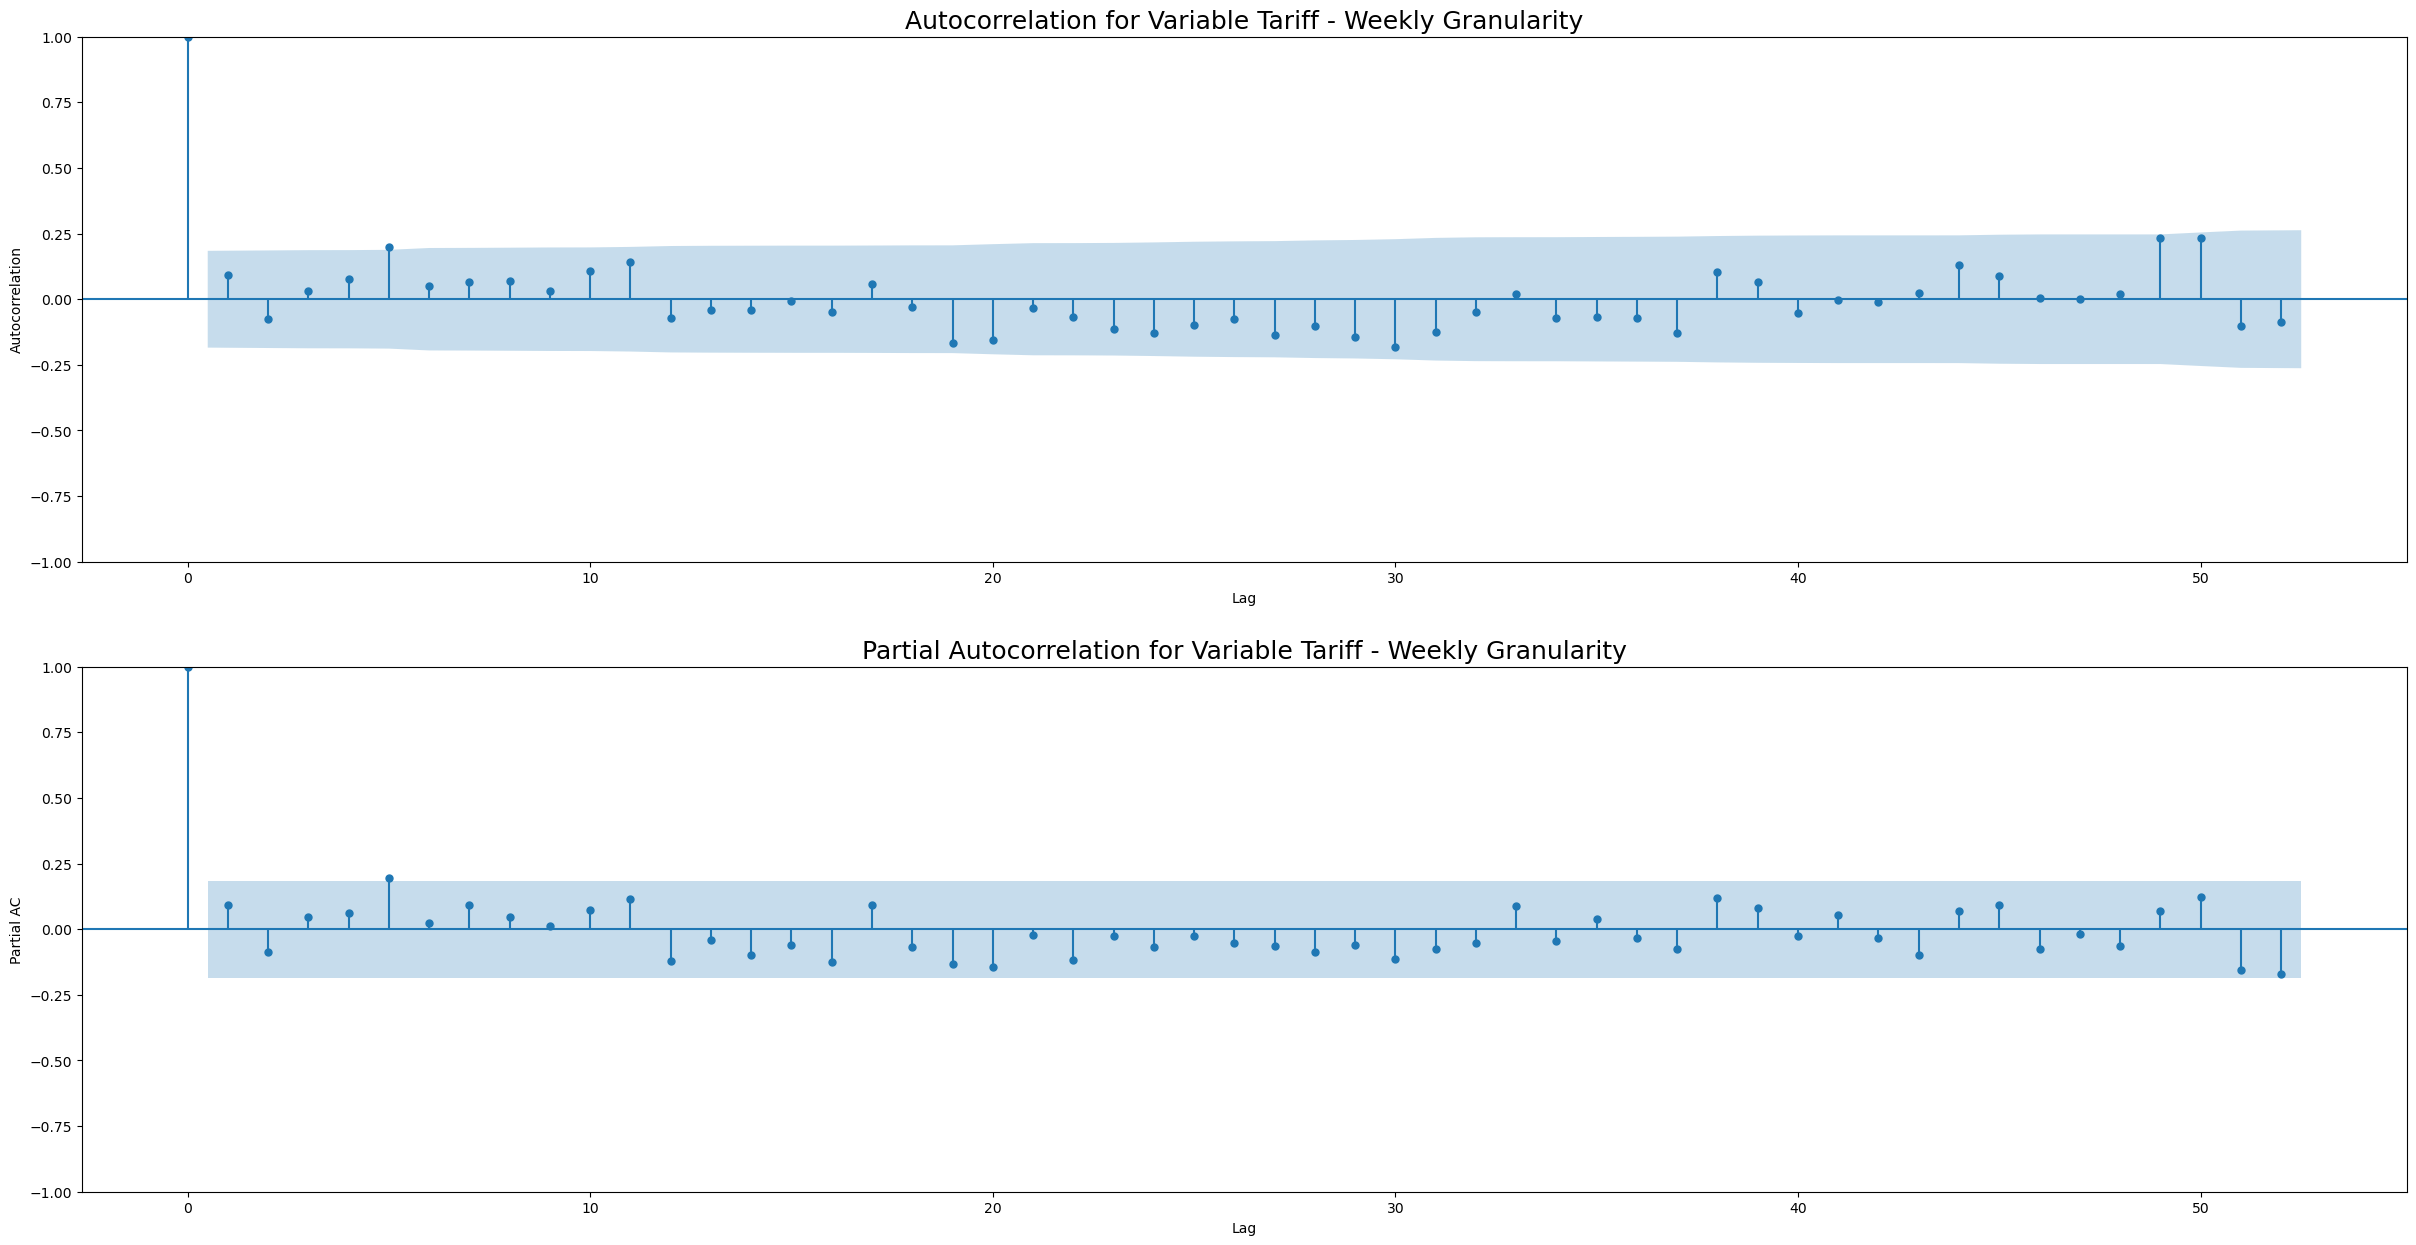

In [17]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(day_df["ToU"].diff(1).dropna(), lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Variable Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(day_df["ToU"].diff(1).dropna(), lags=52, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Variable Tariff - Weekly Granularity', fontsize = 18)
plt.show()

For the variable tariff, we can see that the only point that is outside the area of insignificance on the ACF and PACF graphs is the 5th lag. We will therefore only consider this point in the $p$ and $q$ parameters for our model. This will be done by feeding a single element list into the $p$ and $q$ inputs, consisting of only the 5th lag, `[5]`.

Once again, the series has only been differenced once, so the $d$ parameter will remain as 1.

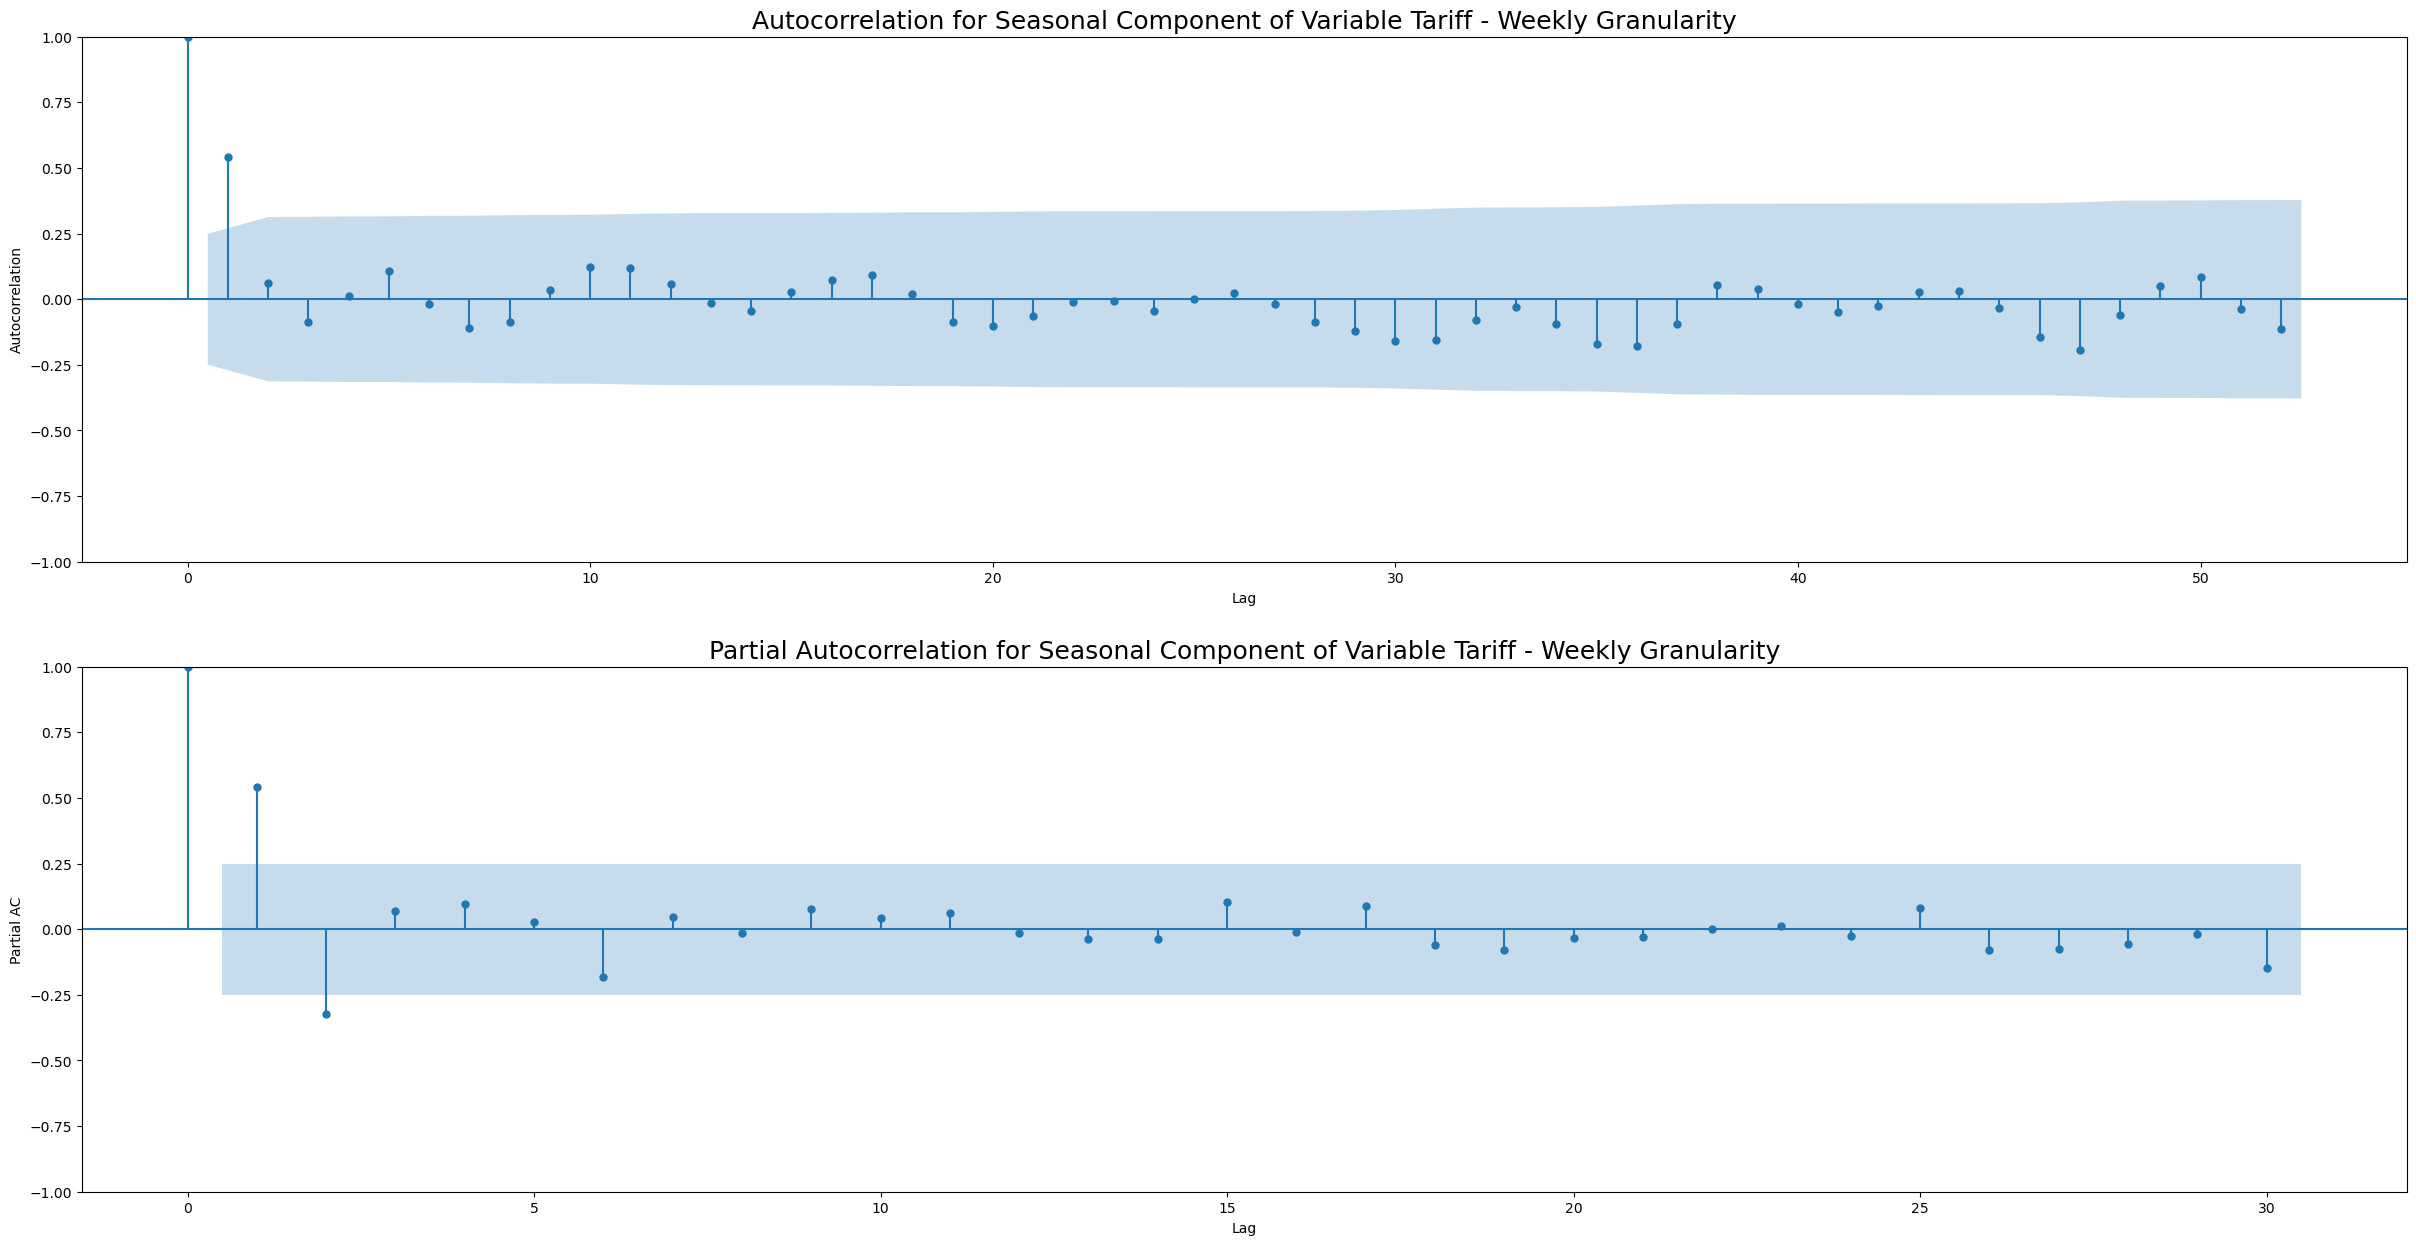

In [18]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(day_df["ToU"].diff(52).dropna(), lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Seasonal Component of Variable Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(day_df["ToU"].diff(52).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Seasonal Component of Variable Tariff - Weekly Granularity', fontsize = 18)
plt.show()

From the seasonal ACF and PACF plots, we see that the seasonal component parameters will remain the same as the standard tariff model. 

$$P = 2 
\\ D = 1 
\\ Q = 1
\\ Seasonal\ Period = 52$$


In [43]:
tscv = TimeSeriesSplit(n_splits=5)
tscv.split(day_df['ToU'])
ToU_mapes = []

for train, test in tscv.split(day_df['ToU']):

    ToU_train = day_df['ToU'][train]
    ToU_test = day_df['ToU'][test]

    SARIMA_ToU = SARIMAX(ToU_train, order=([5], 1, [5]), seasonal_order = (2,1,1,52)) 
    SARIMA_ToU = SARIMA_ToU.fit()

    test_pred = SARIMA_ToU.predict(start = ToU_test.index[0], end = ToU_test.index[-1]).shift(-1).dropna()
    ToU_mapes.append(mean_absolute_percentage_error(ToU_test.head(-1), test_pred))

train_pred = SARIMA_ToU.predict(start = ToU_train.index[0], end = ToU_train.index[-1]).shift(-1).dropna()

print(f'\n\n===========================================\
    \nCross-validated MAPE: {round(np.mean(ToU_mapes)*100, 2)}%\
    \nFinal fold train MAPE: {round(mean_absolute_percentage_error(ToU_train.head(-1), train_pred)*100, 2)}%\
    \nFinal fold test MAPE: {round(mean_absolute_percentage_error(ToU_test.head(-1), test_pred)*100, 2)}%\
    \n===========================================\
    \n\n{SARIMA_ToU.summary()}')




Cross-validated MAPE: 12.12%    
Final fold train MAPE: 2.27%    
Final fold test MAPE: 5.21%    

                                       SARIMAX Results                                        
Dep. Variable:                                    ToU   No. Observations:                   95
Model:             SARIMAX([5], 1, [5])x(2, 1, 1, 52)   Log Likelihood                  84.429
Date:                                Sat, 05 Nov 2022   AIC                           -156.859
Time:                                        15:27:26   BIC                           -146.433
Sample:                                    01-01-2012   HQIC                          -153.037
                                         - 10-20-2013                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

From the first iteration of the model, we can see that $P$ values for many of the parameters are above 0.05. We will begin by dropping the auto-regressive component, as this has the highest $P$ value of the non-seasonal components. In earlier iterations, dropping the seasonal components had no effect on the errors of the model for variable tariffs.

In [44]:
tscv = TimeSeriesSplit(n_splits=5)
tscv.split(day_df['ToU'])
ToU_mapes = []

for train, test in tscv.split(day_df['ToU']):

    ToU_train = day_df['ToU'][train]
    ToU_test = day_df['ToU'][test]

    SARIMA_ToU = SARIMAX(ToU_train, order=(0, 1, [5]), seasonal_order = (2,1,1,52))  # Set p to 0
    SARIMA_ToU = SARIMA_ToU.fit()

    test_pred = SARIMA_ToU.predict(start = ToU_test.index[0], end = ToU_test.index[-1]).shift(-1).dropna()
    ToU_mapes.append(mean_absolute_percentage_error(ToU_test.head(-1), test_pred))

train_pred = SARIMA_ToU.predict(start = ToU_train.index[0], end = ToU_train.index[-1]).shift(-1).dropna()

print(f'\n\n===========================================\
    \nCross-validated MAPE: {round(np.mean(ToU_mapes)*100, 2)}%\
    \nFinal fold train MAPE: {round(mean_absolute_percentage_error(ToU_train.head(-1), train_pred)*100, 2)}%\
    \nFinal fold test MAPE: {round(mean_absolute_percentage_error(ToU_test.head(-1), test_pred)*100, 2)}%\
    \n===========================================\
    \n\n{SARIMA_ToU.summary()}')




Cross-validated MAPE: 11.98%    
Final fold train MAPE: 2.27%    
Final fold test MAPE: 5.1%    

                                      SARIMAX Results                                       
Dep. Variable:                                  ToU   No. Observations:                   95
Model:             SARIMAX(0, 1, [5])x(2, 1, 1, 52)   Log Likelihood                  84.490
Date:                              Sat, 05 Nov 2022   AIC                           -158.981
Time:                                      15:28:17   BIC                           -150.292
Sample:                                  01-01-2012   HQIC                          -155.796
                                       - 10-20-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

We can see that there is a small improvement in the cross validation MAPE. The moving average $P$ value has also reduced, but is still far above the 0.05 significance threshold. We will try dropping this too.

In [45]:
tscv = TimeSeriesSplit(n_splits=5)
tscv.split(day_df['Std'])
ToU_mapes = []

for train, test in tscv.split(day_df['ToU']):

    ToU_train = day_df['ToU'][train]
    ToU_test = day_df['ToU'][test]

    SARIMA_ToU = SARIMAX(ToU_train, order=(0, 1, 0), seasonal_order = (2,1,1,52))    # Set q to 0
    SARIMA_ToU = SARIMA_ToU.fit()

    test_pred = SARIMA_ToU.predict(start = ToU_test.index[0], end = ToU_test.index[-1]).shift(-1).dropna()
    ToU_mapes.append(mean_absolute_percentage_error(ToU_test.head(-1), test_pred))

train_pred = SARIMA_ToU.predict(start = ToU_train.index[0], end = ToU_train.index[-1]).shift(-1).dropna()

print(f'\n\n===========================================\
    \nCross-validated MAPE: {round(np.mean(ToU_mapes)*100, 2)}%\
    \nFinal fold train MAPE: {round(mean_absolute_percentage_error(ToU_train.head(-1), train_pred)*100, 2)}%\
    \nFinal fold test MAPE: {round(mean_absolute_percentage_error(ToU_test.head(-1), test_pred)*100, 2)}%\
    \n===========================================\
    \n\n{SARIMA_ToU.summary()}')



Cross-validated MAPE: 12.22%    
Final fold train MAPE: 2.26%    
Final fold test MAPE: 5.48%    

                                      SARIMAX Results                                       
Dep. Variable:                                  ToU   No. Observations:                   95
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 52)   Log Likelihood                  84.382
Date:                              Sat, 05 Nov 2022   AIC                           -160.764
Time:                                      15:29:36   BIC                           -153.814
Sample:                                  01-01-2012   HQIC                          -158.217
                                       - 10-20-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

Removing the moving average parameter increases the MAPE. This is likely due to the fact that the model no longer has enough information to make an accurate predication. We will keep the moving average term in the model to plot the predictions.

In [46]:
SARIMA_ToU = SARIMAX(ToU_train, order=(0, 1, [5]), seasonal_order = (2,1,1,52)).fit() # Restore q = [5]

In [47]:
ToU_pred_train = SARIMA_ToU.predict(ToU_train.index[0], end=ToU_train.index[-1]).shift(-1).dropna()
ToU_pred_test = SARIMA_ToU.predict(ToU_test.index[0], end=ToU_test.index[-1]).shift(-1).dropna()

In [55]:
fig = go.Figure()
fig.add_trace(go.Line(x=ToU_train.index, y=ToU_train, mode='lines', name="Train"))
fig.add_trace(go.Line(x=ToU_test.index, y=ToU_test, mode='lines', name="Test"))
fig.add_trace(go.Line(x=ToU_train.index, y=ToU_pred_train, mode='lines', name="Train Predictions"))
fig.add_trace(go.Line(x=ToU_test.index, y=ToU_pred_test, mode='lines', name="Test Predictions"))
fig.update_xaxes(title_text = 'Date-Time')
fig.update_yaxes(title_text = 'Power, KW')
fig.update_layout(title = 'SARIMA Performance on Variable Tariff Data')
fig.show()

The plots for both of these models shows that the model predicts on the training data, barring an anomalous prediction on December 23. The test predictions for both models appear slightly higher than the actual data. This is likely due to the fact that there are only two full seasonal cycles in the data. When the data is split for training and testing, the models only have one full seasonal cycle to train. This is likely not enough information for the models to fully capture the seasonality and trend of the data. 

We also see that there are small peaks in the first two cycles around February, which cold be due to shorts bursts of cold weather that did not occur in the 2014 cycle. Both models appear to erroneously assume that these peaks are a repeating pattern, which in turn leads to increased error in the test predictions. This could possibly be reduced by capturing more seasonal cycles, or incorporating an exogenous weather dataset.